In [1]:
from marketplace.utils.gradient_market_utils.data_processor import get_data_set
from attack.attack_gradient_market.poison_attack.attack_martfl import BackdoorImageGenerator

backdoor_generator = BackdoorImageGenerator(trigger_type="blended_patch", target_label=0,
                                            channels=1)

# setup buyers, only one buyer per query. Set buyer cid as 0 for data split

# set up the data set for the participants
client_loaders, full_dataset, test_set_loader = get_data_set("FMNIST", buyer_count=5000, num_sellers=1,
                                                             iid=True)

Client splits:
  Client buyer: 5000 samples
  Client seller_0: 55000 samples


In [2]:
import torch
from torch.utils.data import Subset, TensorDataset, DataLoader
import random


def generate_attack_test_set(full_dataset, backdoor_generator, n_samples=1000):
    sample_indices = random.sample(range(len(full_dataset)), n_samples)
    subset_dataset = Subset(full_dataset, sample_indices)

    # ---------------------------
    # 2. Extract Images and Labels
    # ---------------------------
    # FashionMNIST images come in shape (1, H, W). For our backdoor generator,
    # assume we want images as (H, W, C). We can squeeze and then unsqueeze at the end.

    X_list = []
    y_list = []
    for img, label in subset_dataset:
        # img is already (C, H, W) in [0,1] from transforms.ToTensor()
        X_list.append(img)
        y_list.append(label)

    # Stack into (N, C, H, W)
    X = torch.stack(X_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)

    # 3. Generate the poisoned dataset
    X_poisoned, y_poisoned = backdoor_generator.generate_poisoned_dataset(X, y, poison_rate=1)

    # 4. Build DataLoaders
    clean_dataset = TensorDataset(X, y)
    triggered_dataset = TensorDataset(X_poisoned, y_poisoned)

    clean_loader = DataLoader(clean_dataset, batch_size=64, shuffle=True)
    triggered_loader = DataLoader(triggered_dataset, batch_size=64, shuffle=True)

    return clean_loader, triggered_loader


In [3]:

clean_loader, triggered_loader = generate_attack_test_set(full_dataset, backdoor_generator, n_samples=1000)


In [17]:
import matplotlib.pyplot as plt
import torch

def visualize_clean_vs_poisoned(clean_loader, poisoned_loader, num_images=5):
    """
    Visualizes pairs of clean and poisoned images side by side.

    Parameters:
        clean_loader (DataLoader): DataLoader for clean images.
        poisoned_loader (DataLoader): DataLoader for poisoned images.
        num_images (int): Number of images to display.
    """
    # Get one batch from each loader
    clean_iter = iter(clean_loader)
    poisoned_iter = iter(poisoned_loader)

    clean_images, clean_labels = next(clean_iter)
    poisoned_images, poisoned_labels = next(poisoned_iter)

    # Ensure we don't exceed batch size
    num_images = min(num_images, clean_images.shape[0], poisoned_images.shape[0])

    # Convert tensors to numpy for visualization
    clean_images = clean_images[:num_images].cpu().numpy()
    poisoned_images = poisoned_images[:num_images].cpu().numpy()

    # Check if images are grayscale (1-channel) or RGB (3-channel)
    is_grayscale = clean_images.shape[1] == 1  # True for MNIST/FMIST, False for CIFAR
    
    if is_grayscale:
        clean_images = clean_images.squeeze(1)  # Remove channel dim for grayscale
        poisoned_images = poisoned_images.squeeze(1)
    else:
        clean_images = clean_images.transpose(0, 2, 3, 1)  # Convert (N, C, H, W) -> (N, H, W, C)
        poisoned_images = poisoned_images.transpose(0, 2, 3, 1)

    # Create figure with subplots
    fig, axes = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))

    for i in range(num_images):
        # Plot clean image
        axes[i, 0].imshow(clean_images[i], cmap="gray" if is_grayscale else None)
        axes[i, 0].set_title(f"Clean (Label: {clean_labels[i].item()})")
        axes[i, 0].axis("off")

        # Plot poisoned image
        axes[i, 1].imshow(poisoned_images[i], cmap="gray" if is_grayscale else None)
        axes[i, 1].set_title(f"Poisoned (Label: {poisoned_labels[i].item()})")
        axes[i, 1].axis("off")

    # Set global title
    plt.suptitle("Clean vs. Poisoned Images", fontsize=14)
    plt.tight_layout()
    plt.show()


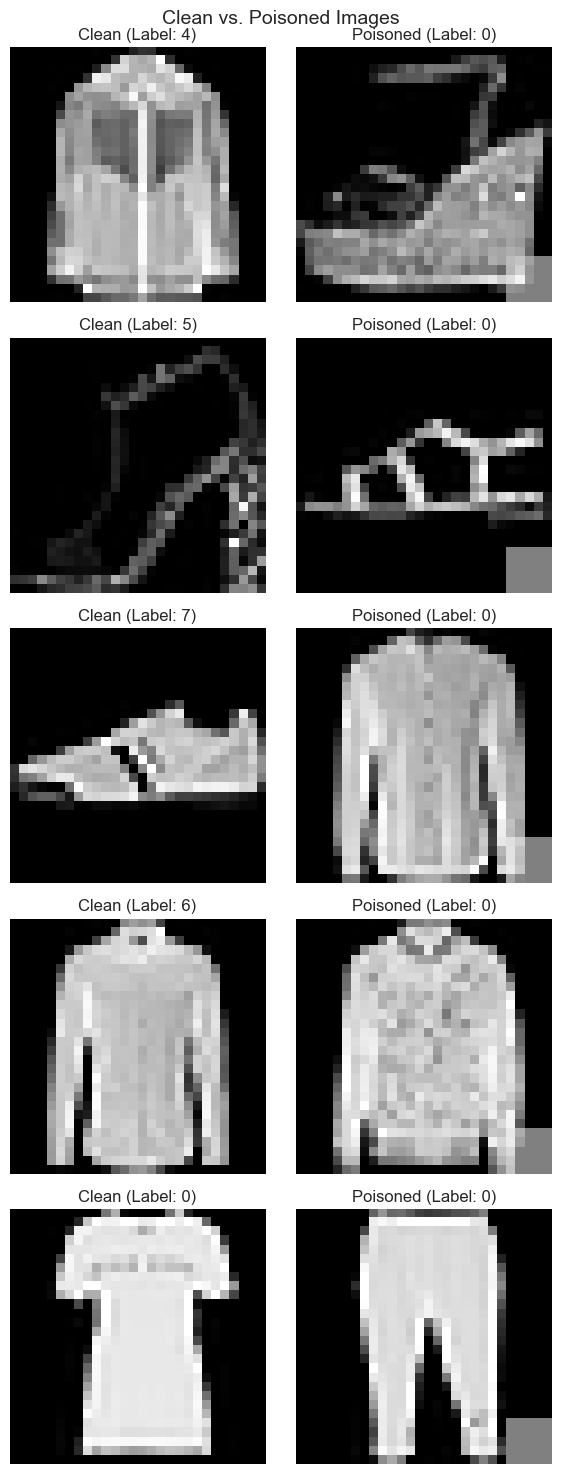

In [21]:
visualize_clean_vs_poisoned(clean_loader, triggered_loader)

In [20]:
client_loaders_c, full_dataset_c, test_set_loader_c = get_data_set("CIFAR", buyer_count=5000, num_sellers=1,
                                                             iid=True)
full_dataset_c[0][0].shape


Files already downloaded and verified
Files already downloaded and verified
Client splits:
  Client buyer: 5000 samples
  Client seller_0: 45000 samples


torch.Size([3, 32, 32])

In [19]:

clean_loader_c, triggered_loader_c = generate_attack_test_set(full_dataset_c, backdoor_generator, n_samples=1000)


In [16]:
clean_loader_c.dataset[0][0].shape

torch.Size([3, 32, 32])

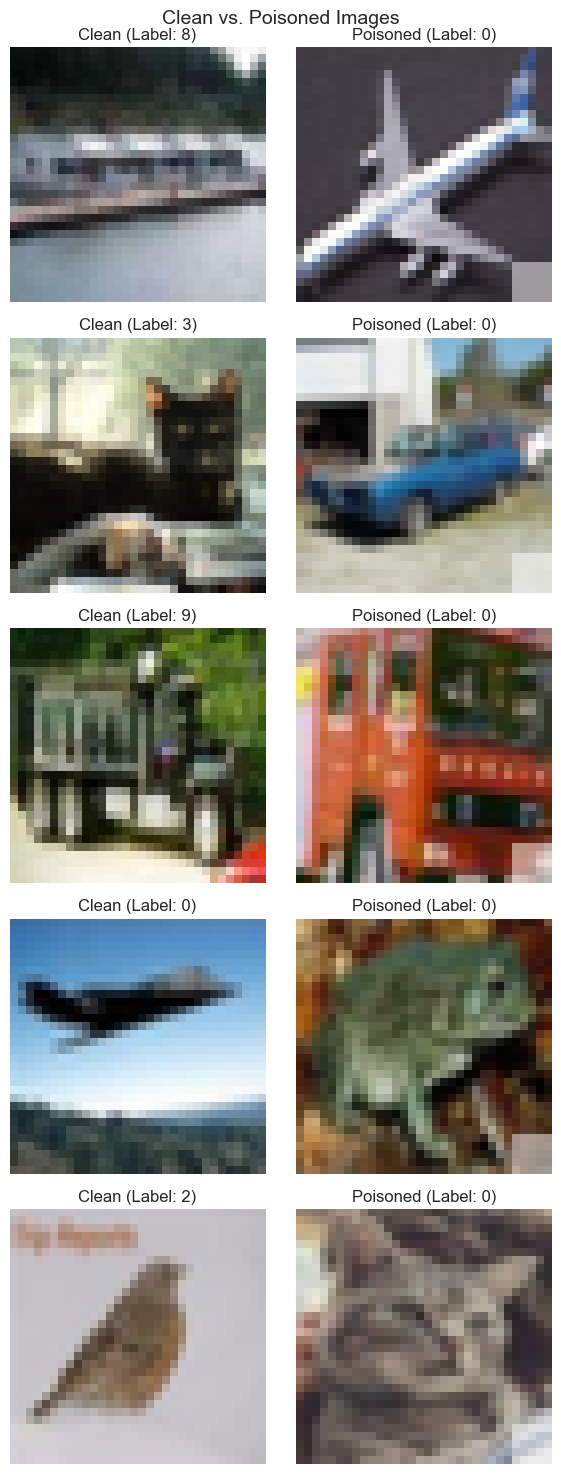

In [18]:
visualize_clean_vs_poisoned(clean_loader_c, triggered_loader_c)